# 基于瓜子二手车数据的二手电动车价格分析以及折价率分析模型

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

warnings.filterwarnings('ignore')
%matplotlib inline


## 数据读取

In [2]:
allData = pd.read_csv('../crawl_for_guazi/data.csv')
print(allData.shape)
allData.head()

(725, 15)


,id,car_name,car_brand,car_tag,price,new_price,complexOutlook,firstCert,odograph,allPower,carBelong,range,isDome,wheelBase,drivingMode
0,116458848,特斯拉 Model 3 2020款 改款 标准续航后驱升级版,特斯拉,Model 3,218000,292751,9成新,2020-12,2.6万公里,202kW,太原(晋),468km,0,2875,后置后驱
1,116339799,宝骏E100 2020款 305KM 智行版,宝骏,宝骏E100,41800,54056,9成新,2021-02,0.4万公里,24kW,台州(浙),305km,1,1600,前置前驱
2,115943401,比亚迪 汉 2020款 EV 四驱高性能版旗舰型,比亚迪,汉,229000,308816,9成新,2020-08,1.9万公里,363kW,成都(川),550km,1,2920,双电机四驱
3,116482432,特斯拉 Model 3 2021款 Performance高性能全轮驱动版,特斯拉,Model 3,306700,368951,9成新,2021-03,1.9万公里,339kW,重庆(渝),605km,0,2875,双电机四驱
4,115679152,特斯拉MODEL S 2014款 MODEL S 85,特斯拉,特斯拉MODEL S,258000,796735,7成新,2015-02,4.7万公里,270kW,烟台(鲁),502km,0,2960,后置后驱


In [3]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              725 non-null    int64 
 1   car_name        725 non-null    object
 2   car_brand       725 non-null    object
 3   car_tag         725 non-null    object
 4   price           725 non-null    int64 
 5   new_price       725 non-null    int64 
 6   complexOutlook  725 non-null    object
 7   firstCert       725 non-null    object
 8   odograph        725 non-null    object
 9   allPower        725 non-null    object
 10  carBelong       725 non-null    object
 11  range           725 non-null    object
 12  isDome          725 non-null    int64 
 13  wheelBase       725 non-null    int64 
 14  drivingMode     725 non-null    object
dtypes: int64(5), object(10)
memory usage: 85.1+ KB


In [4]:
allData.describe()

,id,price,new_price,isDome,wheelBase
count,7.250000e+02,725.000000,725.000000,725.000000,725.000000
mean,1.162238e+08,146077.653793,217050.737931,0.696552,2593.925517
std,2.977155e+05,103589.988294,141576.877095,0.460065,363.794524
min,1.130053e+08,12800.000000,0.000000,0.000000,1600.000000
25%,1.160014e+08,60000.000000,95304.000000,0.000000,2475.000000
50%,1.163161e+08,109800.000000,195167.000000,1.000000,2680.000000
75%,1.164450e+08,229800.000000,306428.000000,1.000000,2875.000000
max,1.165670e+08,728000.000000,947506.000000,1.000000,3110.000000


In [5]:
print(len(allData['car_brand'].unique()))

58


## 数据清洗

1. 该部分目的为将带单位的属性变为纯数字型属性，如将“7成新”变为“7”，以及时间属性，里程去单位
2. 具体的：
   1. 将成色属性去除尾部中文，并转换为float类型
   2. 将上牌年月属性转为时间单位，并增加一列“使用时间“，表示从首次上牌至今的天数
   3. 表显里程以纯数字形式显示，注意列表中带有”万“时需乘10000
   4. 车辆总功率去单位
   5. 续航里程去单位

### 1. 处理外观成色属性字段，将其转换为float类型

In [6]:
def dealOutlookStr(str):
    if type(str) is float:
        return str
    str = str.rstrip('成新')
    if len(str) > 1 and '.' not in str:
        str = float(str) / 10
    return str

allData['complexOutlook'] = allData['complexOutlook'].map(lambda x: np.float(dealOutlookStr(x)))
allData['complexOutlook'].describe()

count    725.000000
mean       8.713103
std        0.813241
min        6.000000
25%        8.000000
50%        9.000000
75%        9.000000
max        9.900000
Name: complexOutlook, dtype: float64

### 2. 将首次上牌修改为pandas.datetime形式，并新增一列表示从上牌至数据获取时(2022-01-26)的天数



In [7]:
allData['firstCert'] = pd.to_datetime(allData['firstCert'],format='%Y-%m')
allData['daysGone'] = ((pd.to_datetime('2022-02-26') - allData['firstCert']).dt.days)
allData['daysGone']

0       452
1       390
2       574
3       362
4      2582
       ... 
720     818
721     482
722    1183
723    1701
724     209
Name: daysGone, Length: 725, dtype: int64

### 3. 处理表显里程数

In [8]:
def dealOdograph(str):
    if type(str) is float:
        return str
    str = str.rstrip('公里')
    if '万' in str:
        str = str.rstrip('万')
        str = float(str) * 10000
    return float(str)

allData['odograph'] = allData['odograph'].map(dealOdograph)
allData['odograph'].describe()

count       725.000000
mean      20173.655172
std       20176.160883
min         100.000000
25%        5000.000000
50%       15000.000000
75%       30000.000000
max      142000.000000
Name: odograph, dtype: float64

### 4. 处理车辆总功率

In [9]:
allData['allPower'] = allData['allPower'].map(lambda x: float(x.rstrip('kW')))

In [10]:
# 处理车辆续航里程
allData['range'].describe()
# temp = allData['range'].map(lambda x: 'km' in x)
# temp.unique()
def dealRange(str):
    if str is '-' or str is None:
        return None
    if type(str) is int:
        return str
    str = str.rstrip('km')
    return int(str)
allData['range'] = allData['range'].map(dealRange)

### 5. 删除new_price为0的行

In [11]:
allData = allData.drop(index=allData[allData['new_price'] == 0].index)

### 6. 添加损耗价格与损耗价格率
depreciation = new_price - price  
%depreciation = depriciation / new_price

In [12]:
def depri(df):
    return df['new_price'] - df['price'] if df['new_price'] - df['price'] > 0 else 0

def depri_per(df):
    return df['depri'] / df['new_price'] if df['new_price'] > 0 else 0

def preserve_per(df):
    return df['price'] / df['new_price'] if df['new_price'] > 0 else 0

allData['depri'] = allData.apply(depri, axis=1)
allData['depri_ratio'] = allData.apply(depri_per, axis=1)
allData['preserve_ratio'] = allData.apply(preserve_per, axis=1)

### 7. 清洗后的数据描述

In [13]:
allData.describe()

,id,price,new_price,complexOutlook,odograph,allPower,range,isDome,wheelBase,daysGone,depri,depri_ratio,preserve_ratio
count,7.240000e+02,724.000000,724.000000,724.000000,724.000000,724.000000,692.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,1.162236e+08,146083.562155,217350.531768,8.712707,20200.138122,139.159945,377.606936,0.696133,2593.378453,550.564917,71287.251381,0.316259,0.684127
std,2.978655e+05,103661.480293,141444.282475,0.813733,20177.495578,103.870466,153.396637,0.460244,363.747481,466.951581,71197.840051,0.205304,0.205983
min,1.130053e+08,12800.000000,31261.000000,6.000000,100.000000,15.000000,52.000000,0.000000,1600.000000,25.000000,0.000000,0.000000,0.077174
25%,1.160012e+08,59950.000000,95304.000000,8.000000,5000.000000,45.000000,270.000000,0.000000,2475.000000,209.000000,22534.500000,0.161810,0.557930
50%,1.163161e+08,109650.000000,195167.000000,9.000000,15000.000000,135.000000,400.000000,1.000000,2680.000000,421.000000,54303.500000,0.257076,0.742924
75%,1.164451e+08,229800.000000,306428.000000,9.000000,30000.000000,202.000000,500.000000,1.000000,2875.000000,818.000000,91748.250000,0.442070,0.838190
max,1.165670e+08,728000.000000,947506.000000,9.900000,142000.000000,577.000000,712.000000,1.000000,3110.000000,2582.000000,538735.000000,0.922826,1.120087


In [14]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724 entries, 0 to 724
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              724 non-null    int64         
 1   car_name        724 non-null    object        
 2   car_brand       724 non-null    object        
 3   car_tag         724 non-null    object        
 4   price           724 non-null    int64         
 5   new_price       724 non-null    int64         
 6   complexOutlook  724 non-null    float64       
 7   firstCert       724 non-null    datetime64[ns]
 8   odograph        724 non-null    float64       
 9   allPower        724 non-null    float64       
 10  carBelong       724 non-null    object        
 11  range           692 non-null    float64       
 12  isDome          724 non-null    int64         
 13  wheelBase       724 non-null    int64         
 14  drivingMode     724 non-null    object        
 15  daysGo

## 数据分析

### 1. 查看折价率为0的行  
车辆的二手价格甚至超过了新车的价格，这是不常见的

In [15]:
allData[allData['preserve_ratio'] > 1]

,id,car_name,car_brand,car_tag,price,new_price,complexOutlook,firstCert,odograph,allPower,carBelong,range,isDome,wheelBase,drivingMode,daysGone,depri,depri_ratio,preserve_ratio
424,116433745,零跑汽车 零跑T03 2020款 400标准版,零跑汽车,零跑T03,80000,71423,9.0,2021-06-01,14000.0,55.0,温州(浙),403.0,0,2400,前置前驱,270,0,0.0,1.120087
544,115705191,五菱汽车 宏光MINI EV 2020款 轻松款 磷酸铁锂,五菱,宏光MINI EV,33000,31261,9.5,2021-06-01,2000.0,20.0,唐山(冀),120.0,1,1940,后置后驱,270,0,0.0,1.055628
670,115701297,五菱汽车 宏光MINI EV 2020款 悦享款 磷酸铁锂,五菱,宏光MINI EV,42800,42116,9.5,2022-01-01,100.0,20.0,安顺(贵),170.0,1,1940,后置后驱,56,0,0.0,1.016241
719,116304498,五菱汽车 宏光MINI EV 2020款 悦享款 磷酸铁锂,五菱,宏光MINI EV,45800,42116,9.0,2021-01-01,9000.0,20.0,上海(沪),170.0,1,1940,后置后驱,421,0,0.0,1.087473


### 2. 对特征与保值率做可视化统计

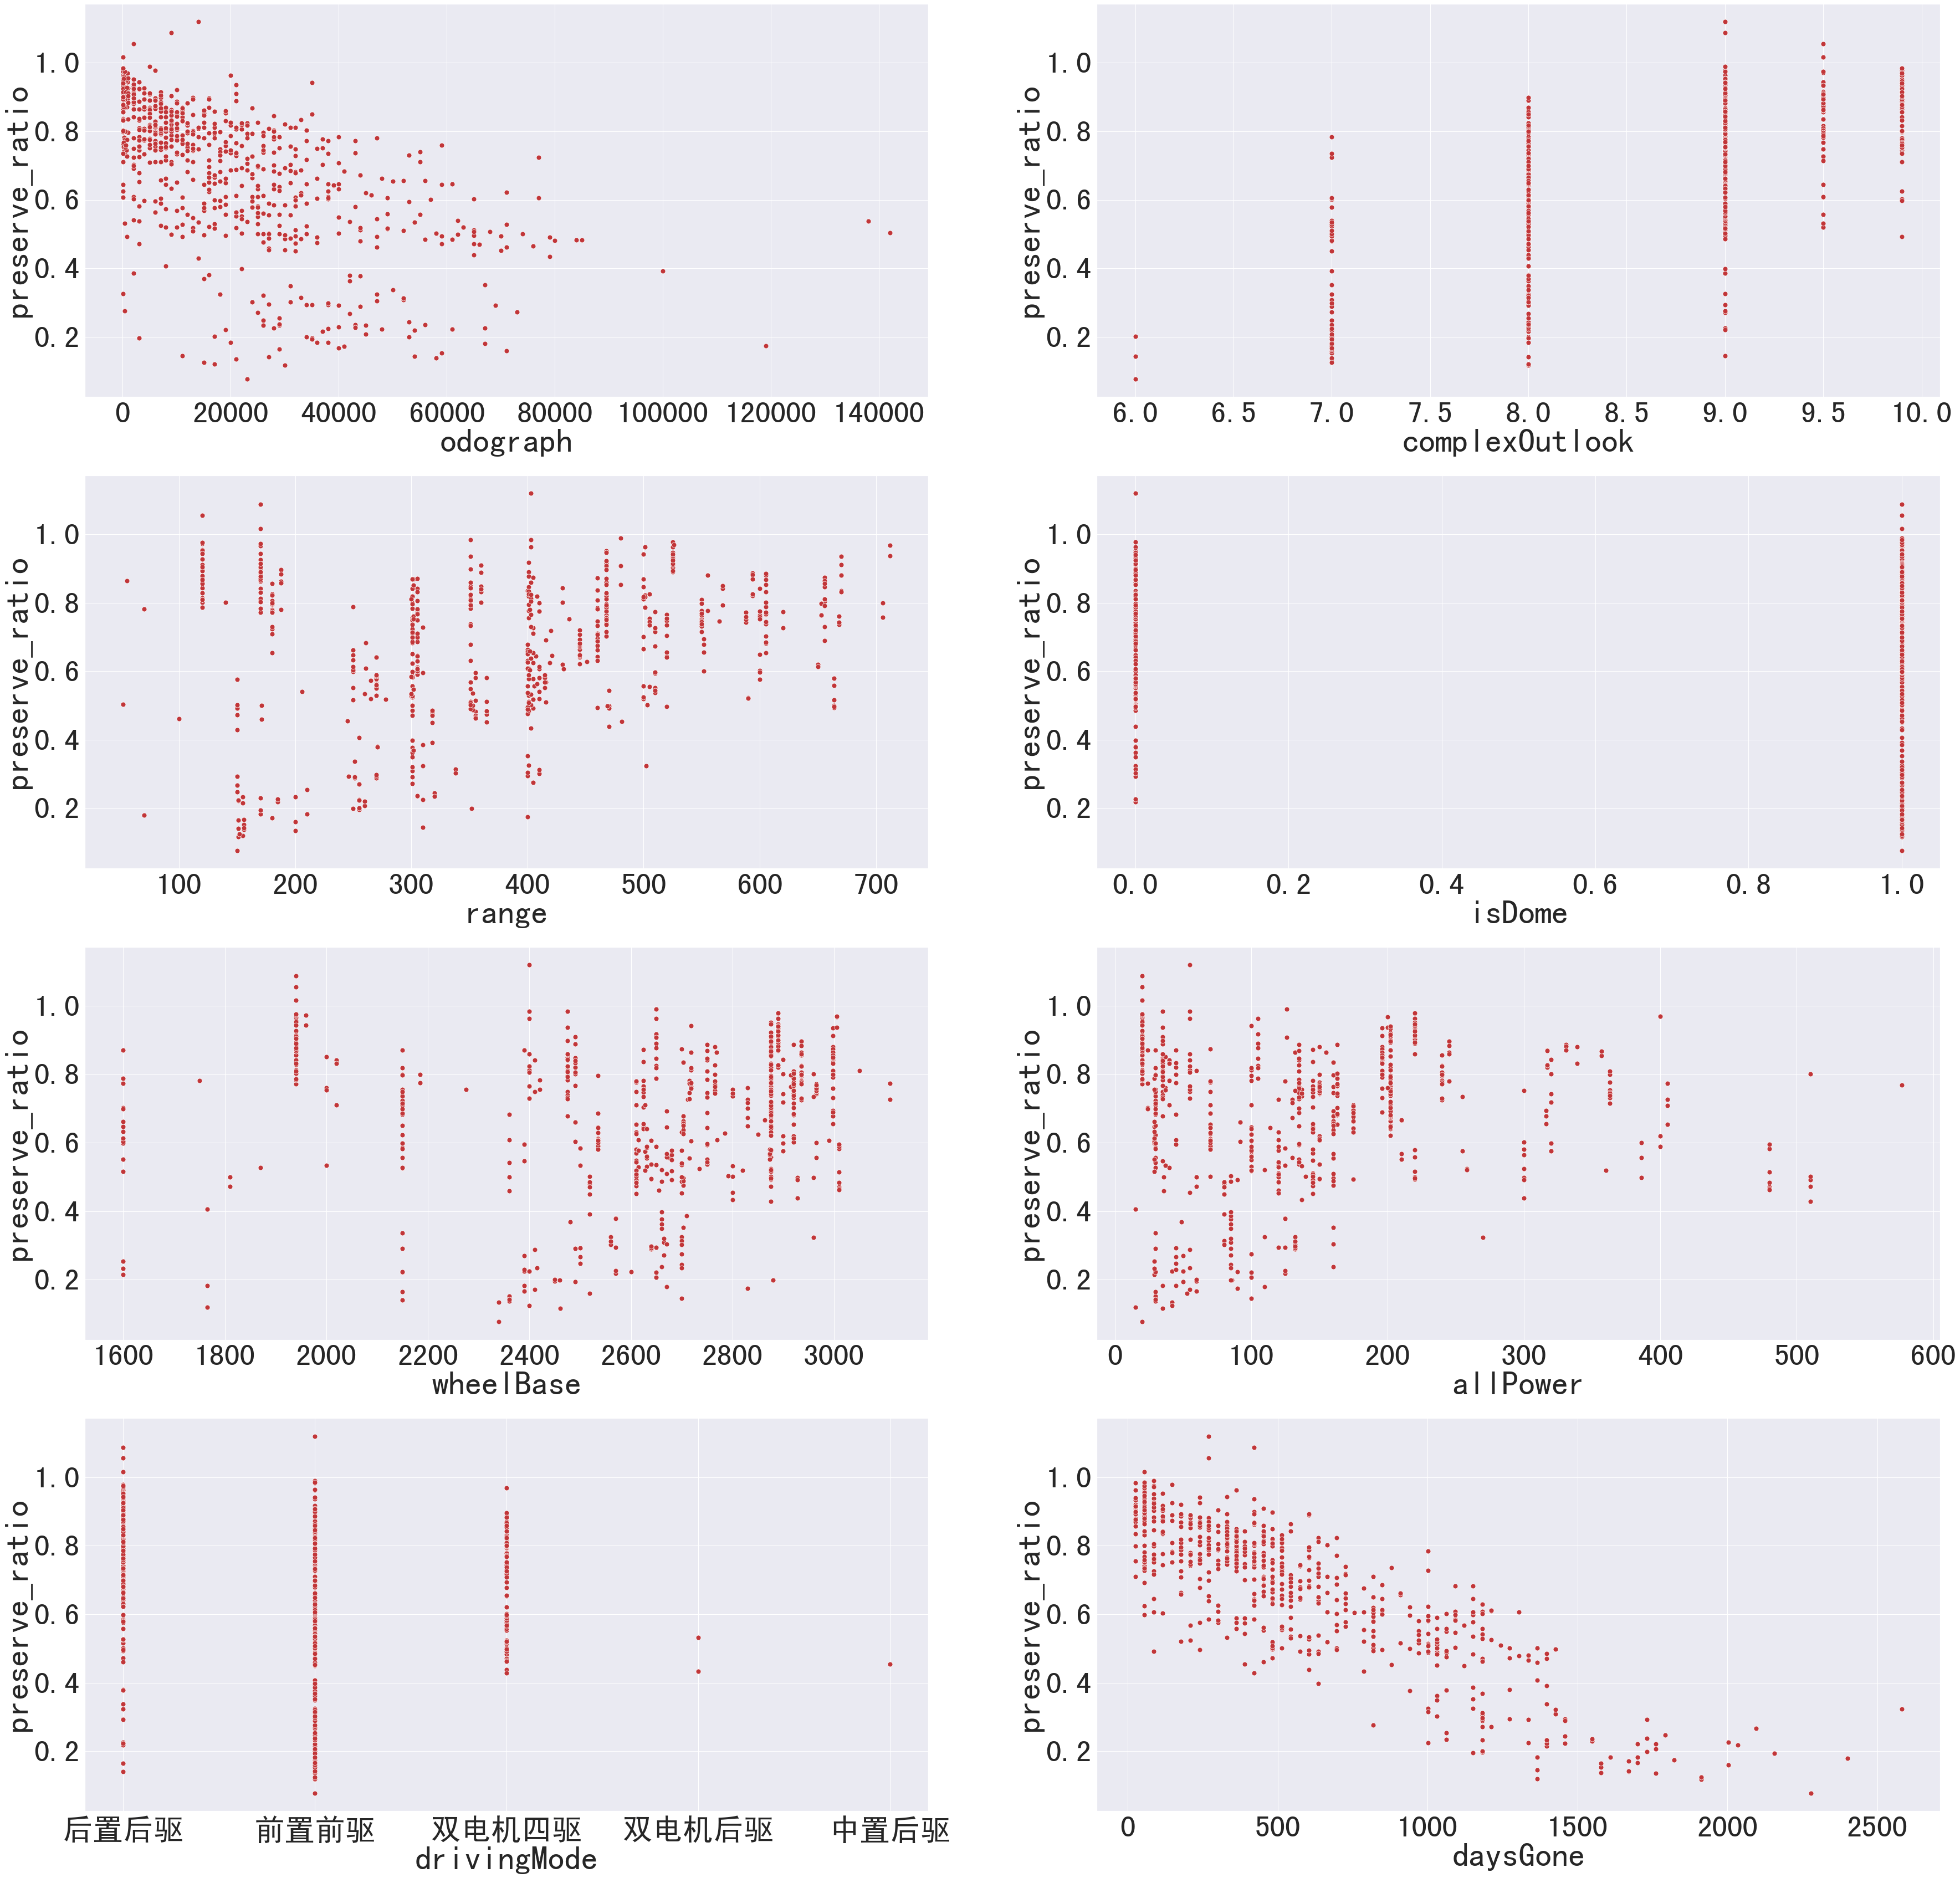

In [58]:
rc = {'font.sans-serif': 'SimHei', 'axes.unicode_minus': False}
sns.set(rc=rc, palette = "RdBu", font_scale = 5)
figure, axes = plt.subplots(4, 2, figsize=(60,60))
sns.scatterplot(allData['odograph'], allData['preserve_ratio'], ax=axes[0][0], s=80)
sns.scatterplot(allData['complexOutlook'], allData['preserve_ratio'], ax=axes[0][1], s=80)
sns.scatterplot(allData['range'], allData['preserve_ratio'], ax=axes[1][0], s=80)
sns.scatterplot(allData['isDome'], allData['preserve_ratio'], ax=axes[1][1], s=80)
sns.scatterplot(allData['wheelBase'], allData['preserve_ratio'], ax=axes[2][0], s=80)
sns.scatterplot(allData['allPower'], allData['preserve_ratio'], ax=axes[2][1], s=80)
sns.scatterplot(allData['drivingMode'], allData['preserve_ratio'], ax=axes[3][0], s=80)
sns.scatterplot(allData['daysGone'], allData['preserve_ratio'], ax=axes[3][1], s=80)
plt.show()

### 3. 筛选排名靠前的品牌并查看相关性

In [61]:
dict = allData['car_brand'].value_counts()
dict.sort_values(ascending=True)
dict = dict[:10]

tempdf = allData[allData['car_brand'].isin(dict.keys())]
tempdf.describe()

,id,price,new_price,complexOutlook,odograph,allPower,range,isDome,wheelBase,daysGone,depri,depri_ratio,preserve_ratio
count,5.250000e+02,525.000000,525.000000,525.000000,525.000000,525.000000,498.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000
mean,1.162343e+08,150996.379048,204975.598095,8.795429,18662.857143,132.544381,379.018072,0.655238,2574.664762,494.363810,53990.851429,0.262761,0.737542
std,2.722364e+05,104364.964284,132738.652883,0.775666,19331.228232,94.324926,162.772142,0.475744,392.028622,429.123346,55250.316097,0.175333,0.175848
min,1.151689e+08,22000.000000,31261.000000,6.000000,100.000000,20.000000,52.000000,0.000000,1600.000000,25.000000,0.000000,0.000000,0.135017
25%,1.160008e+08,53800.000000,80107.000000,8.000000,4000.000000,35.000000,253.250000,0.000000,2360.000000,178.000000,19056.000000,0.134827,0.645573
50%,1.163222e+08,126000.000000,192996.000000,9.000000,13000.000000,145.000000,400.500000,1.000000,2670.000000,421.000000,42329.000000,0.222546,0.777454
75%,1.164489e+08,233900.000000,308816.000000,9.000000,27000.000000,202.000000,520.000000,1.000000,2890.000000,635.000000,71704.000000,0.354427,0.865173
max,1.165650e+08,728000.000000,947506.000000,9.900000,142000.000000,577.000000,706.000000,1.000000,3050.000000,2582.000000,538735.000000,0.864983,1.087473


<AxesSubplot:xlabel='car_brand', ylabel='preserve_ratio'>

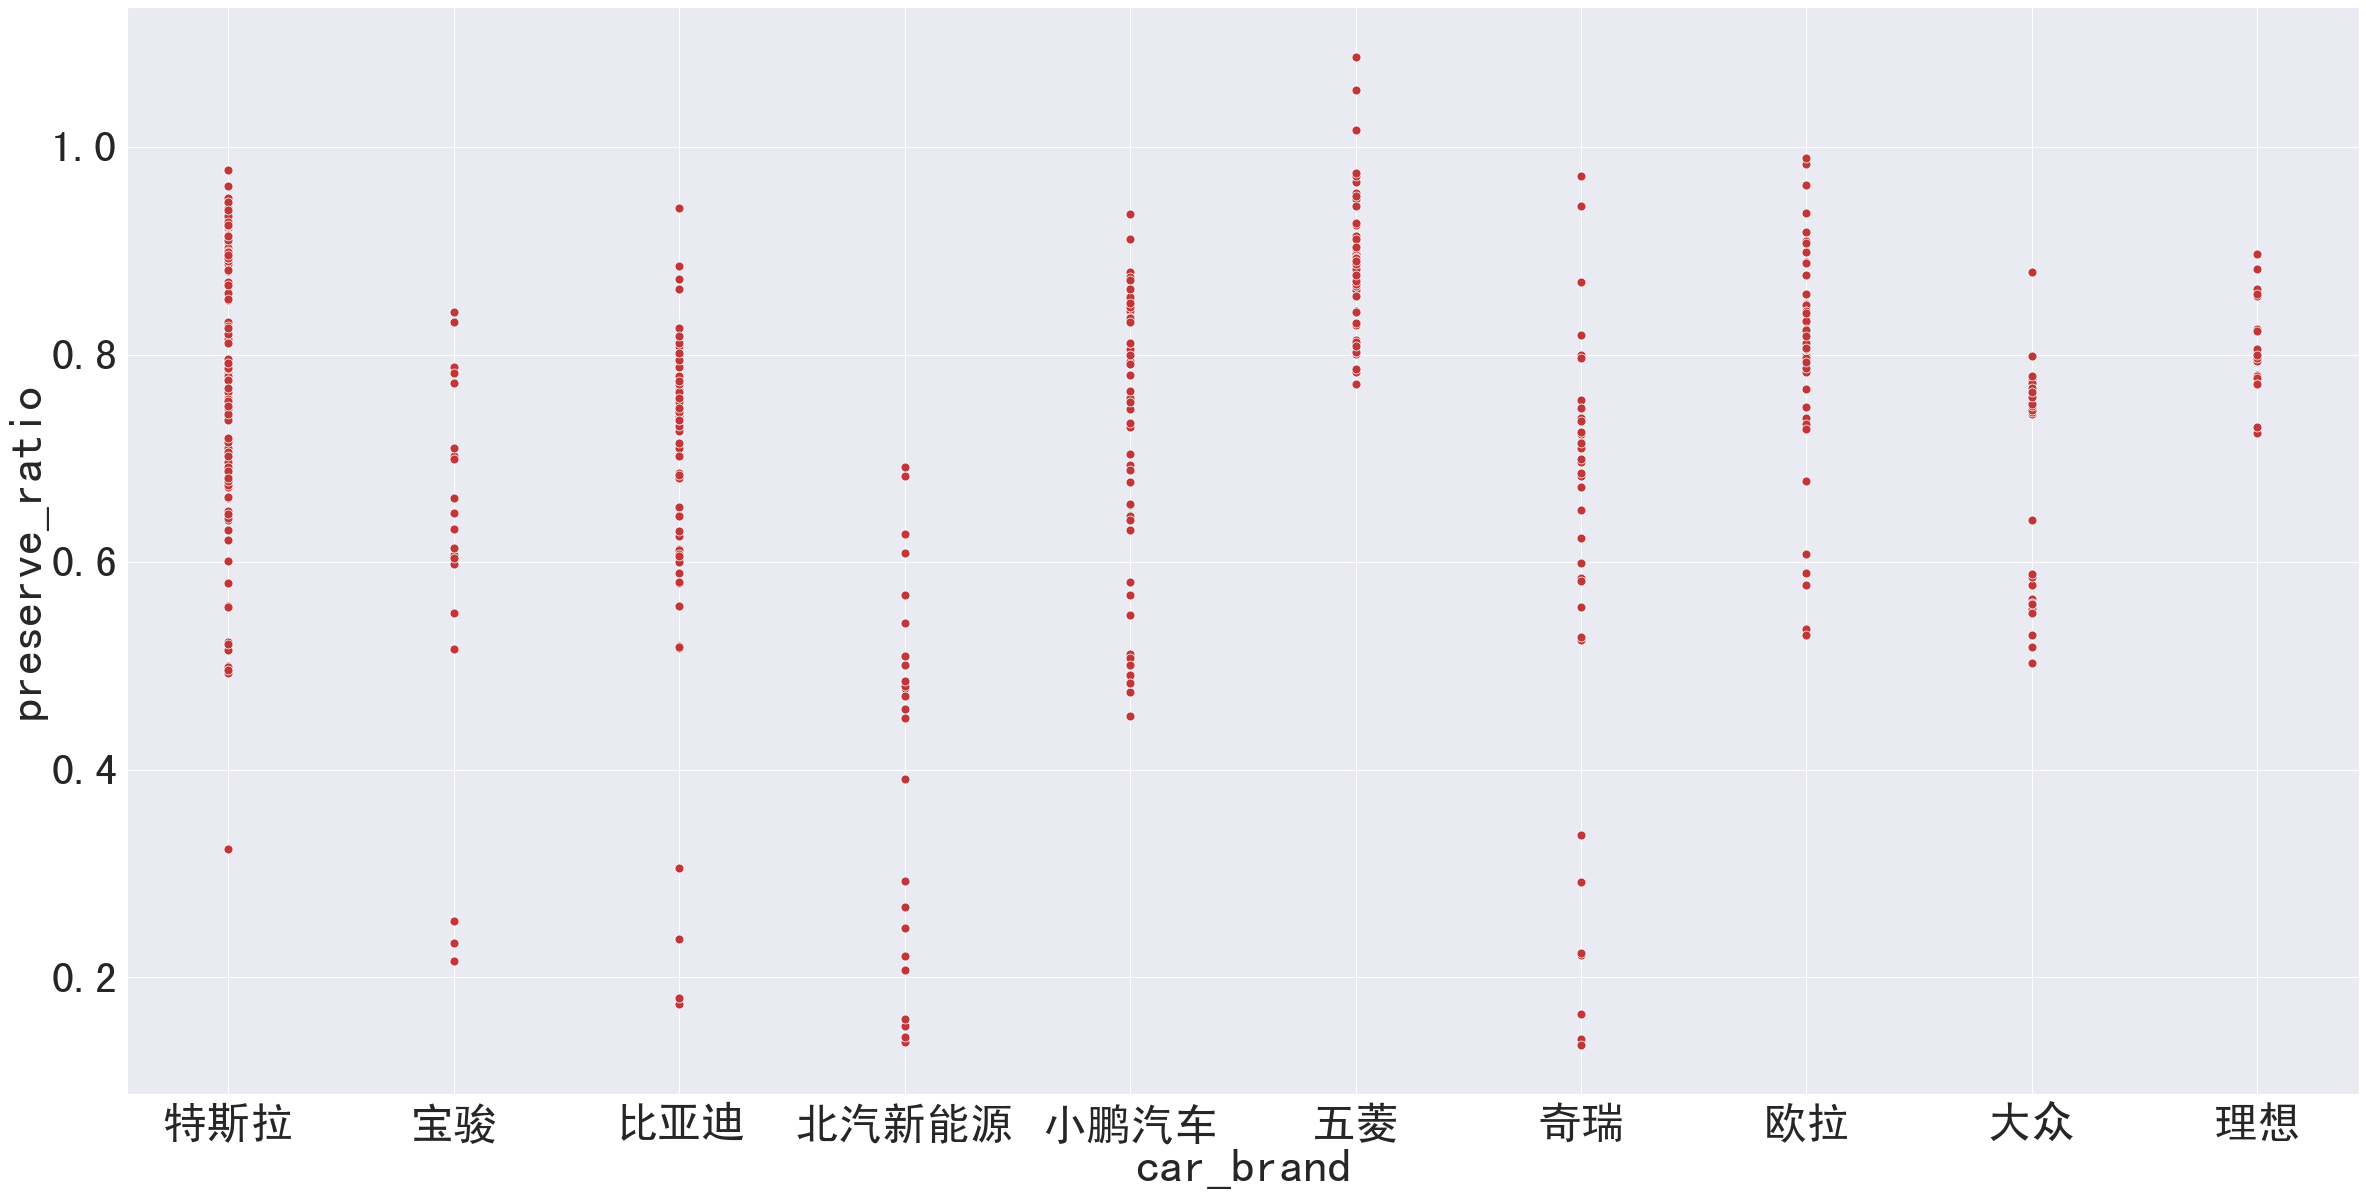

In [63]:
sns.set(rc=rc, palette = "RdBu", font_scale = 4)
figure, axes = plt.subplots(1, 1, figsize=(40,20))
sns.scatterplot(tempdf['car_brand'], tempdf['preserve_ratio'], s=80)

### 3. 分地区查看保值率是否与地区有关

In [19]:
dict = allData['carBelong'].value_counts()
dict.sort_values(ascending=True)
dict = dict[:10]

tempdf = allData[allData['carBelong'].isin(dict.keys())]
tempdf.describe()

,id,price,new_price,complexOutlook,odograph,allPower,range,isDome,wheelBase,daysGone,depri,depri_ratio,preserve_ratio
count,3.180000e+02,318.000000,318.000000,318.000000,318.000000,318.000000,307.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,1.162332e+08,163255.342767,242268.764151,8.701258,21334.591195,163.742138,401.957655,0.694969,2681.327044,523.509434,79025.006289,0.315090,0.685185
std,3.143401e+05,98554.707554,135830.083160,0.751905,20941.146273,108.435430,153.928751,0.461146,306.461436,425.877604,68276.005504,0.180225,0.180773
min,1.130053e+08,12800.000000,31261.000000,6.000000,100.000000,20.000000,52.000000,0.000000,1600.000000,25.000000,0.000000,0.000000,0.077174
25%,1.161425e+08,80050.000000,144828.000000,8.000000,6000.000000,85.000000,301.000000,0.000000,2610.000000,209.000000,33345.000000,0.191086,0.567900
50%,1.163163e+08,144750.000000,255458.500000,9.000000,16000.000000,150.000000,403.000000,1.000000,2750.000000,452.000000,62242.500000,0.266961,0.733039
75%,1.164464e+08,233550.000000,316740.000000,9.000000,29750.000000,202.000000,520.000000,1.000000,2890.000000,696.000000,99758.500000,0.432100,0.808914
max,1.165650e+08,728000.000000,947506.000000,9.900000,142000.000000,577.000000,712.000000,1.000000,3050.000000,2401.000000,382902.000000,0.922826,1.087473


<AxesSubplot:xlabel='carBelong', ylabel='preserve_ratio'>

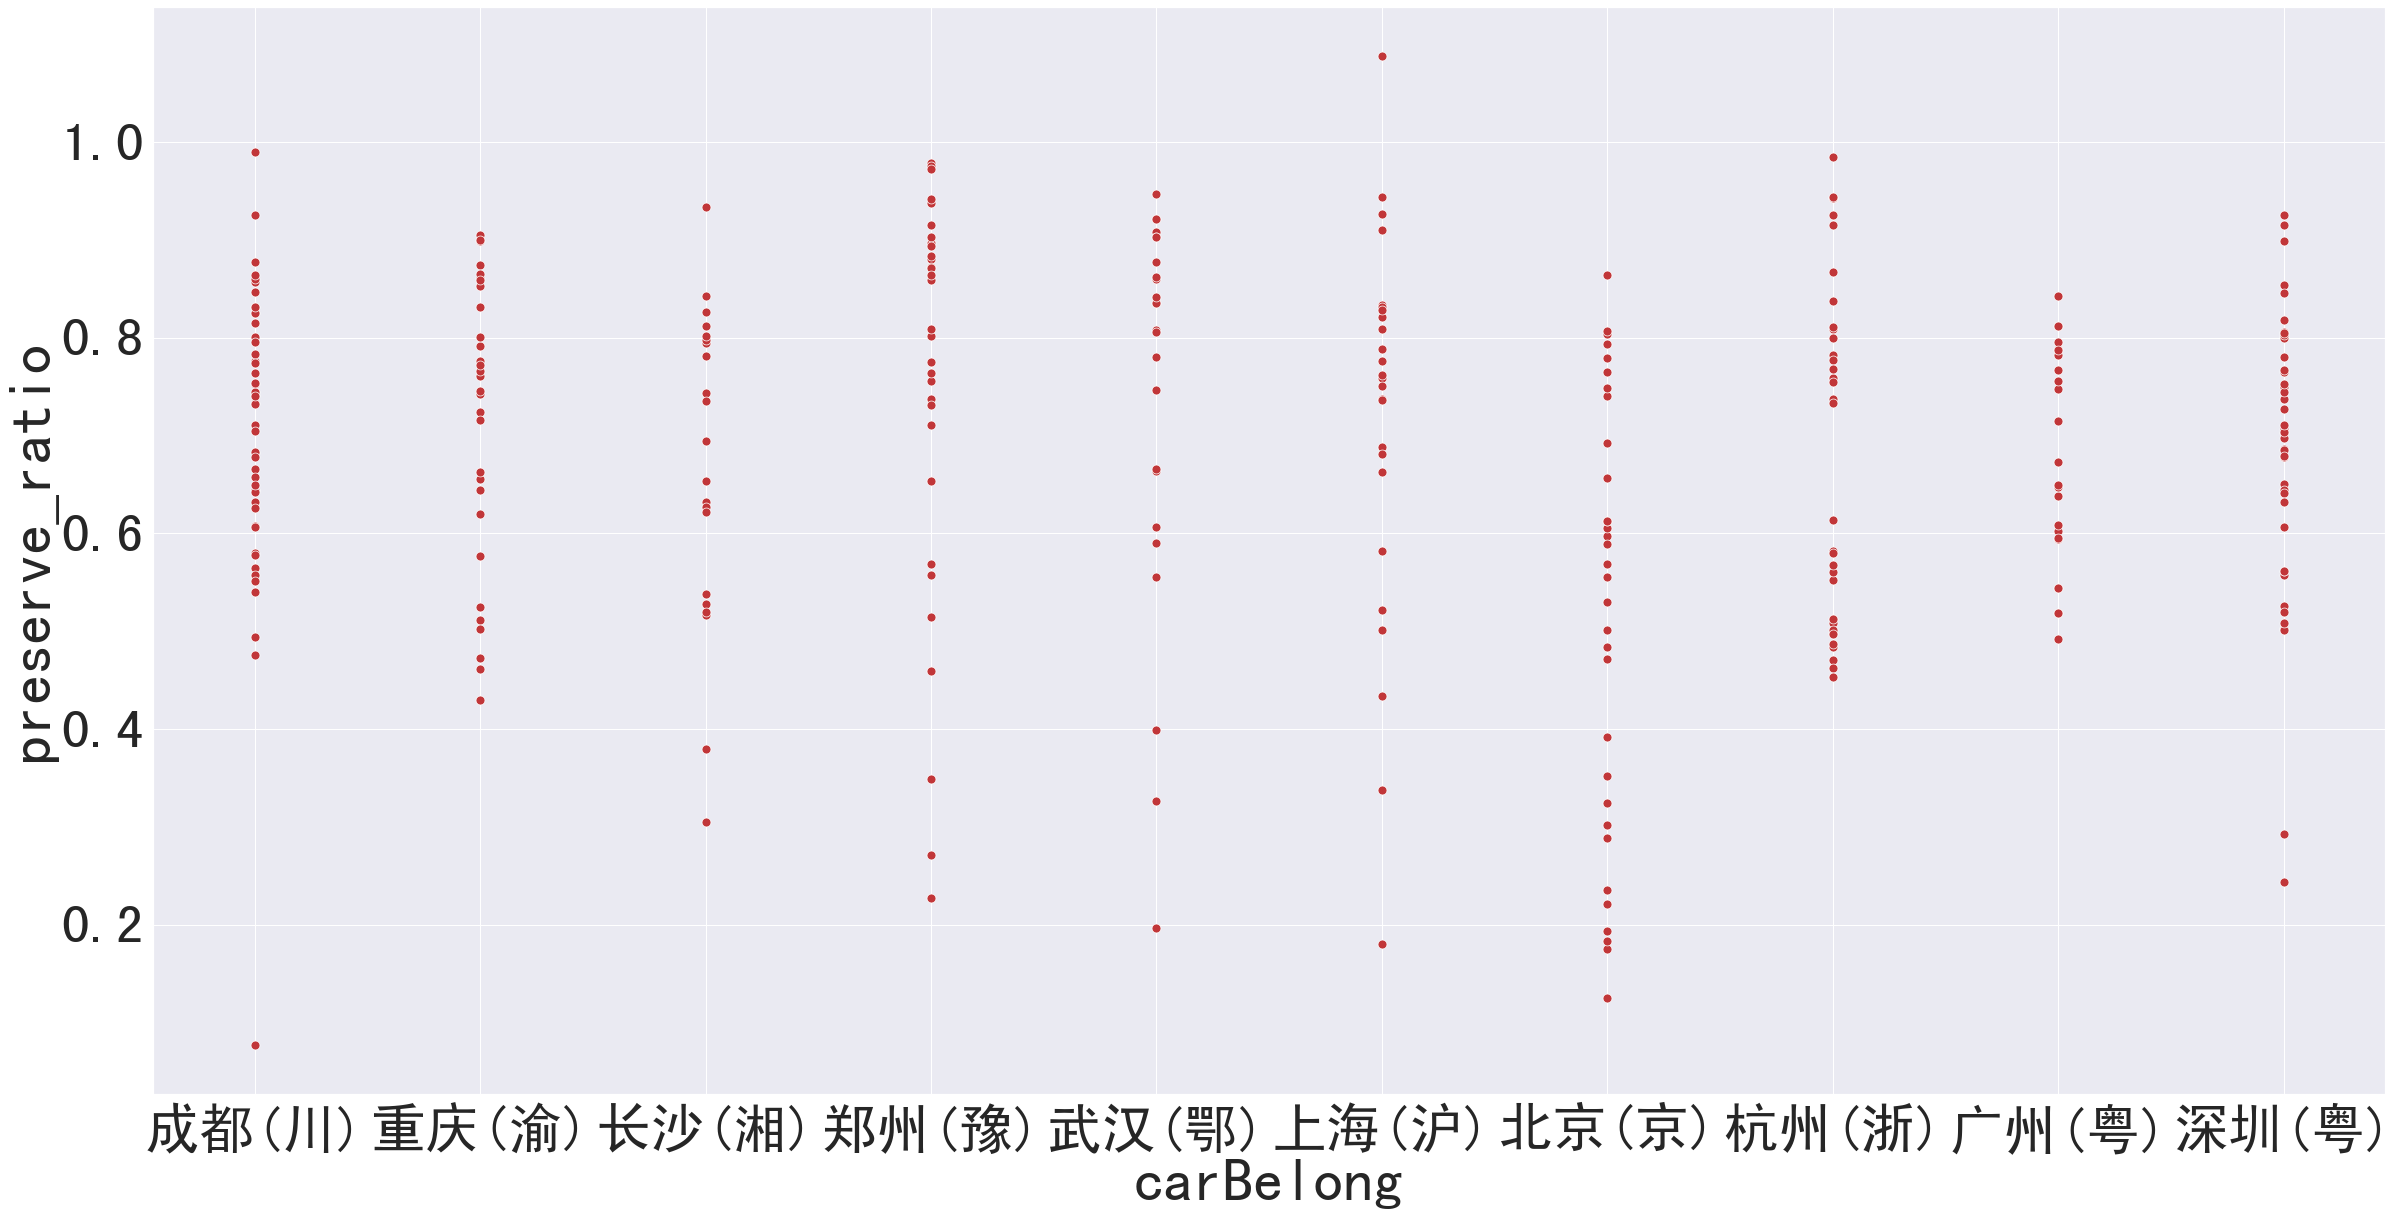

In [60]:
sns.set(rc=rc, palette = "RdBu", font_scale = 5)
figure, axes = plt.subplots(1, 1, figsize=(40,20))
sns.scatterplot(tempdf['carBelong'], tempdf['preserve_ratio'], s=80)

## 模型预测

### 1. 分离训练集与测试集

将车辆品牌、车辆标签、新车价格（元）、整体外观成色、首次上牌至今时间（天）、表显里程（km）、总功率（kW）、车辆归属地、续航里程（km）、是否为国内生产、轴距（mm）、驱动方式作为特征向量。

将车辆保值率`preserve_ratio`作为标签。

划分时`random_state=42`。

In [21]:
# 模型预测

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

allData.columns

Index(['id', 'car_name', 'car_brand', 'car_tag', 'price', 'new_price',
       'complexOutlook', 'firstCert', 'odograph', 'allPower', 'carBelong',
       'range', 'isDome', 'wheelBase', 'drivingMode', 'daysGone', 'depri',
       'depri_ratio', 'preserve_ratio'],
      dtype='object')

In [22]:
X = pd.DataFrame(allData, columns=['new_price', 'complexOutlook', 'daysGone', 'odograph', \
                                   'allPower', 'range', 'isDome', 'wheelBase'])
X_with_char = pd.DataFrame(allData, columns=['car_brand', 'car_tag', 'new_price', \
                                   'complexOutlook', 'daysGone', 'odograph', \
                                   'allPower', 'carBelong', 'range', \
                                   'isDome', 'wheelBase', 'drivingMode'])
y = pd.DataFrame(allData, columns=['preserve_ratio'])

使用one-hot编码处理车辆品牌、车辆型号、驱动方式字段保存到X_dummies中。

In [23]:
X_dummies = pd.get_dummies(X_with_char, prefix=['car_brand', 'car_tag', 'carBelong', 'drivingMode'])
X_dummies.columns

Index(['new_price', 'complexOutlook', 'daysGone', 'odograph', 'allPower',
       'range', 'isDome', 'wheelBase', 'car_brand_ARCFOX',
       'car_brand_ARCFOX极狐',
       ...
       'carBelong_青岛(鲁)', 'carBelong_鞍山(辽)', 'carBelong_韶关(粤)',
       'carBelong_黄冈(鄂)', 'carBelong_黄石(鄂)', 'drivingMode_中置后驱',
       'drivingMode_前置前驱', 'drivingMode_双电机后驱', 'drivingMode_双电机四驱',
       'drivingMode_后置后驱'],
      dtype='object', length=320)

In [24]:
X_dummies = X_dummies.replace(np.nan, 0)
X_dummies_train, X_dummies_test, y_dummies_train, y_dummies_test = train_test_split(X_dummies, y, test_size=0.33, random_state=42)

X_dummies_train_without_time = X_dummies_train.drop(columns=['daysGone'])
X_dummies_test_without_time = X_dummies_test.drop(columns=['daysGone'])

X = X.replace(np.nan, 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_without_time = X_train.drop(columns=['daysGone'])
X_test_without_time = X_test.drop(columns=['daysGone'])

说明：  
`X` 为**不**包含车辆品牌/型号/归属地/驱动方式的标签数据集`X_train, X_test, y_train, y_test`  
`X_with_char` 为包含上述特征的标签数据集  
`X_dummies` 是将`X_with_char`进行one-hot处理后的标签数据集`X_dummies_train, X_dummies_test, y_dummies_train, y_dummies_test`  
`X_without_time` 是不包含时间特征的标签数据集`X_train_without_time, X_test_without_time, y_train, y_test`

### 2. 随机森林

#### 不带dummies，带时间属性的RF

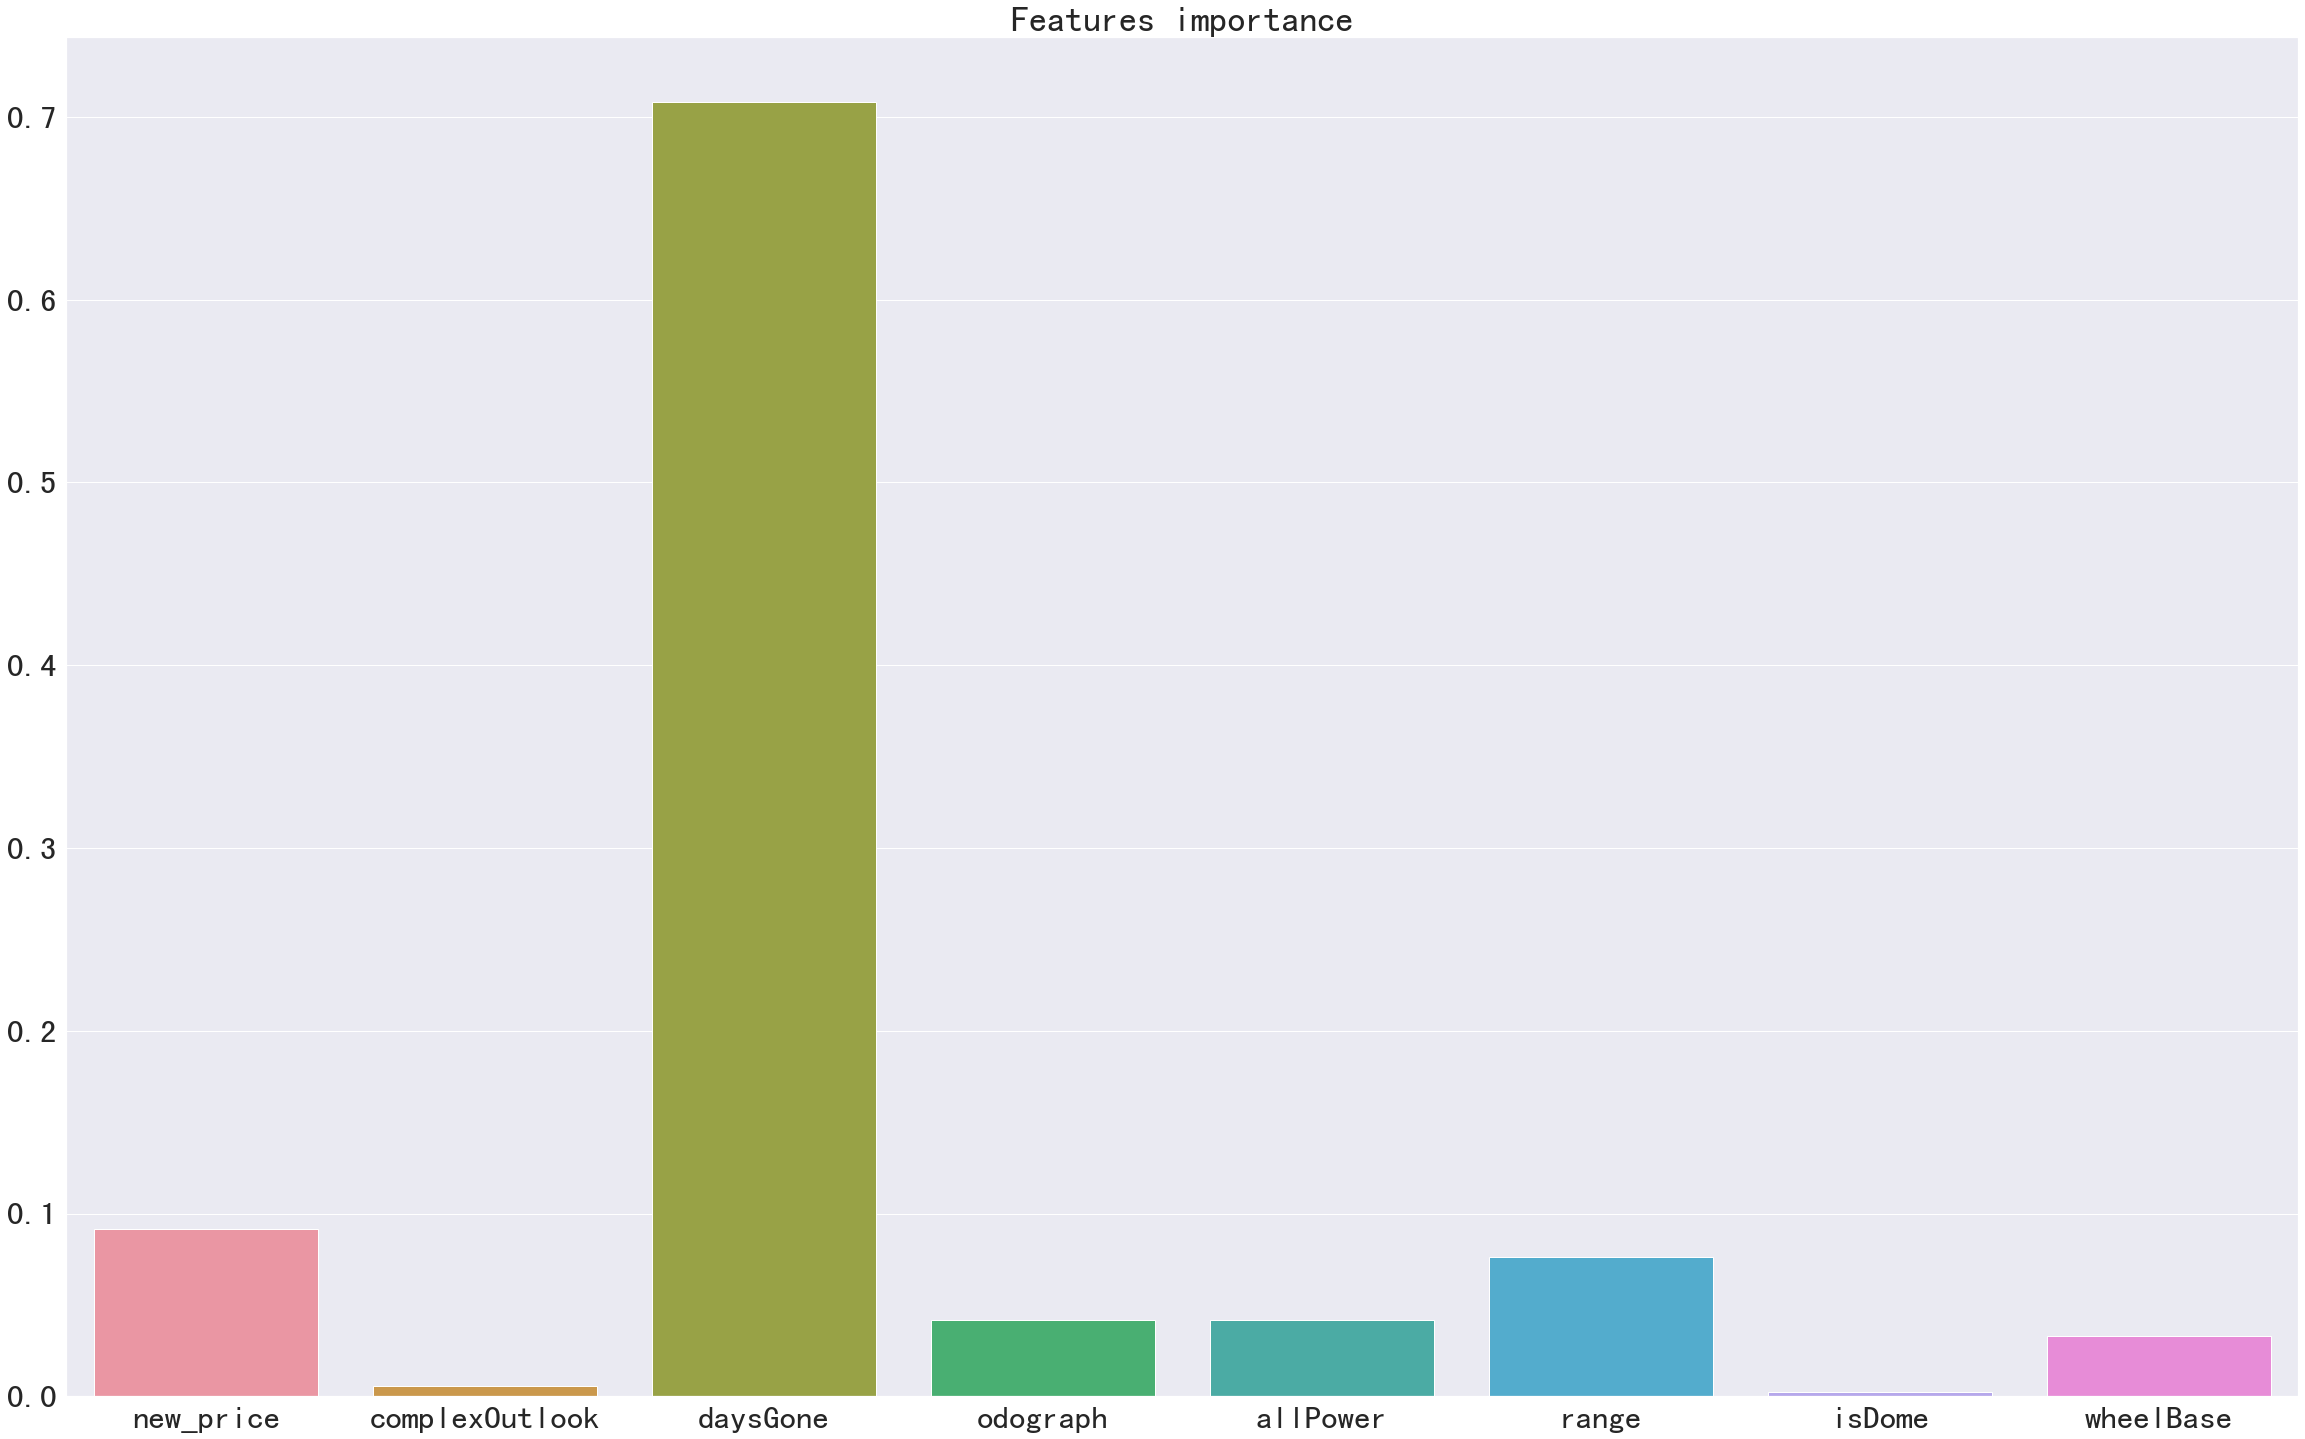

In [25]:
from sklearn.ensemble import RandomForestRegressor

rf_with_time = RandomForestRegressor()
rf_with_time.fit(X_train, y_train)

fig, ax = plt.subplots(1, 1, figsize=(40, 25))
labels = X.columns
sns.barplot(x=labels, y=rf_with_time.feature_importances_)
ax.set_title('Features importance')
plt.show()

In [26]:
print(rf_with_time.feature_importances_)

[0.09151195 0.00549576 0.70811233 0.04157015 0.04161424 0.07615447
 0.00235497 0.03318613]


In [27]:
y_predict = rf_with_time.predict(X_test)
print('RF considering no dummies has MAE: ', mean_absolute_error(y_test, y_predict))
print('RF considering no dummies has r2 score: ', r2_score(y_test, y_predict))

RF considering no dummies has MAE:  0.04897550803251065
RF considering no dummies has r2 score:  0.8868262160256556


对随机森林回归模型调参

In [28]:
from sklearn.model_selection import GridSearchCV
#  {'max_features': 7,
#   'min_samples_leaf': 1,
#   'min_samples_split': 4,
#   'n_estimators': 20})
# param_test = {'n_estimators': range(10,101,10),
#                'max_features': range(1,11,1),
#                'min_samples_leaf': range(1,11,1),
#                'min_samples_split': range(1,11,1)}
# gsearch1 = GridSearchCV(estimator = RandomForestRegressor(), 
#                        param_grid = param_test)
# gsearch1.fit(X_train, y_train)
# gsearch1.best_score_, gsearch1.best_params_
gsearch_result = RandomForestRegressor(n_estimators=20, max_features=7, min_samples_leaf=1, min_samples_split=4)
gsearch_result.fit(X_train, y_train)

RandomForestRegressor(max_features=7, min_samples_split=4, n_estimators=20)

保存精度最高的模型参数到`model/rf_no_dummies.pickle`

In [29]:
print('RF considering no dummies with best params has MAE: ', mean_absolute_error(y_test, gsearch_result.predict(X_test)))
print('RF considering no dummies with best params has r2 score: ', r2_score(y_test, gsearch_result.predict(X_test)))
pickle_file = open('rf_no_dummies.pickle', 'wb')
pickle.dump(gsearch_result, pickle_file)

RF considering no dummies with best params has MAE:  0.05202839765334402
RF considering no dummies with best params has r2 score:  0.8794268561591863


#### 不带dummies，不带时间属性的RF

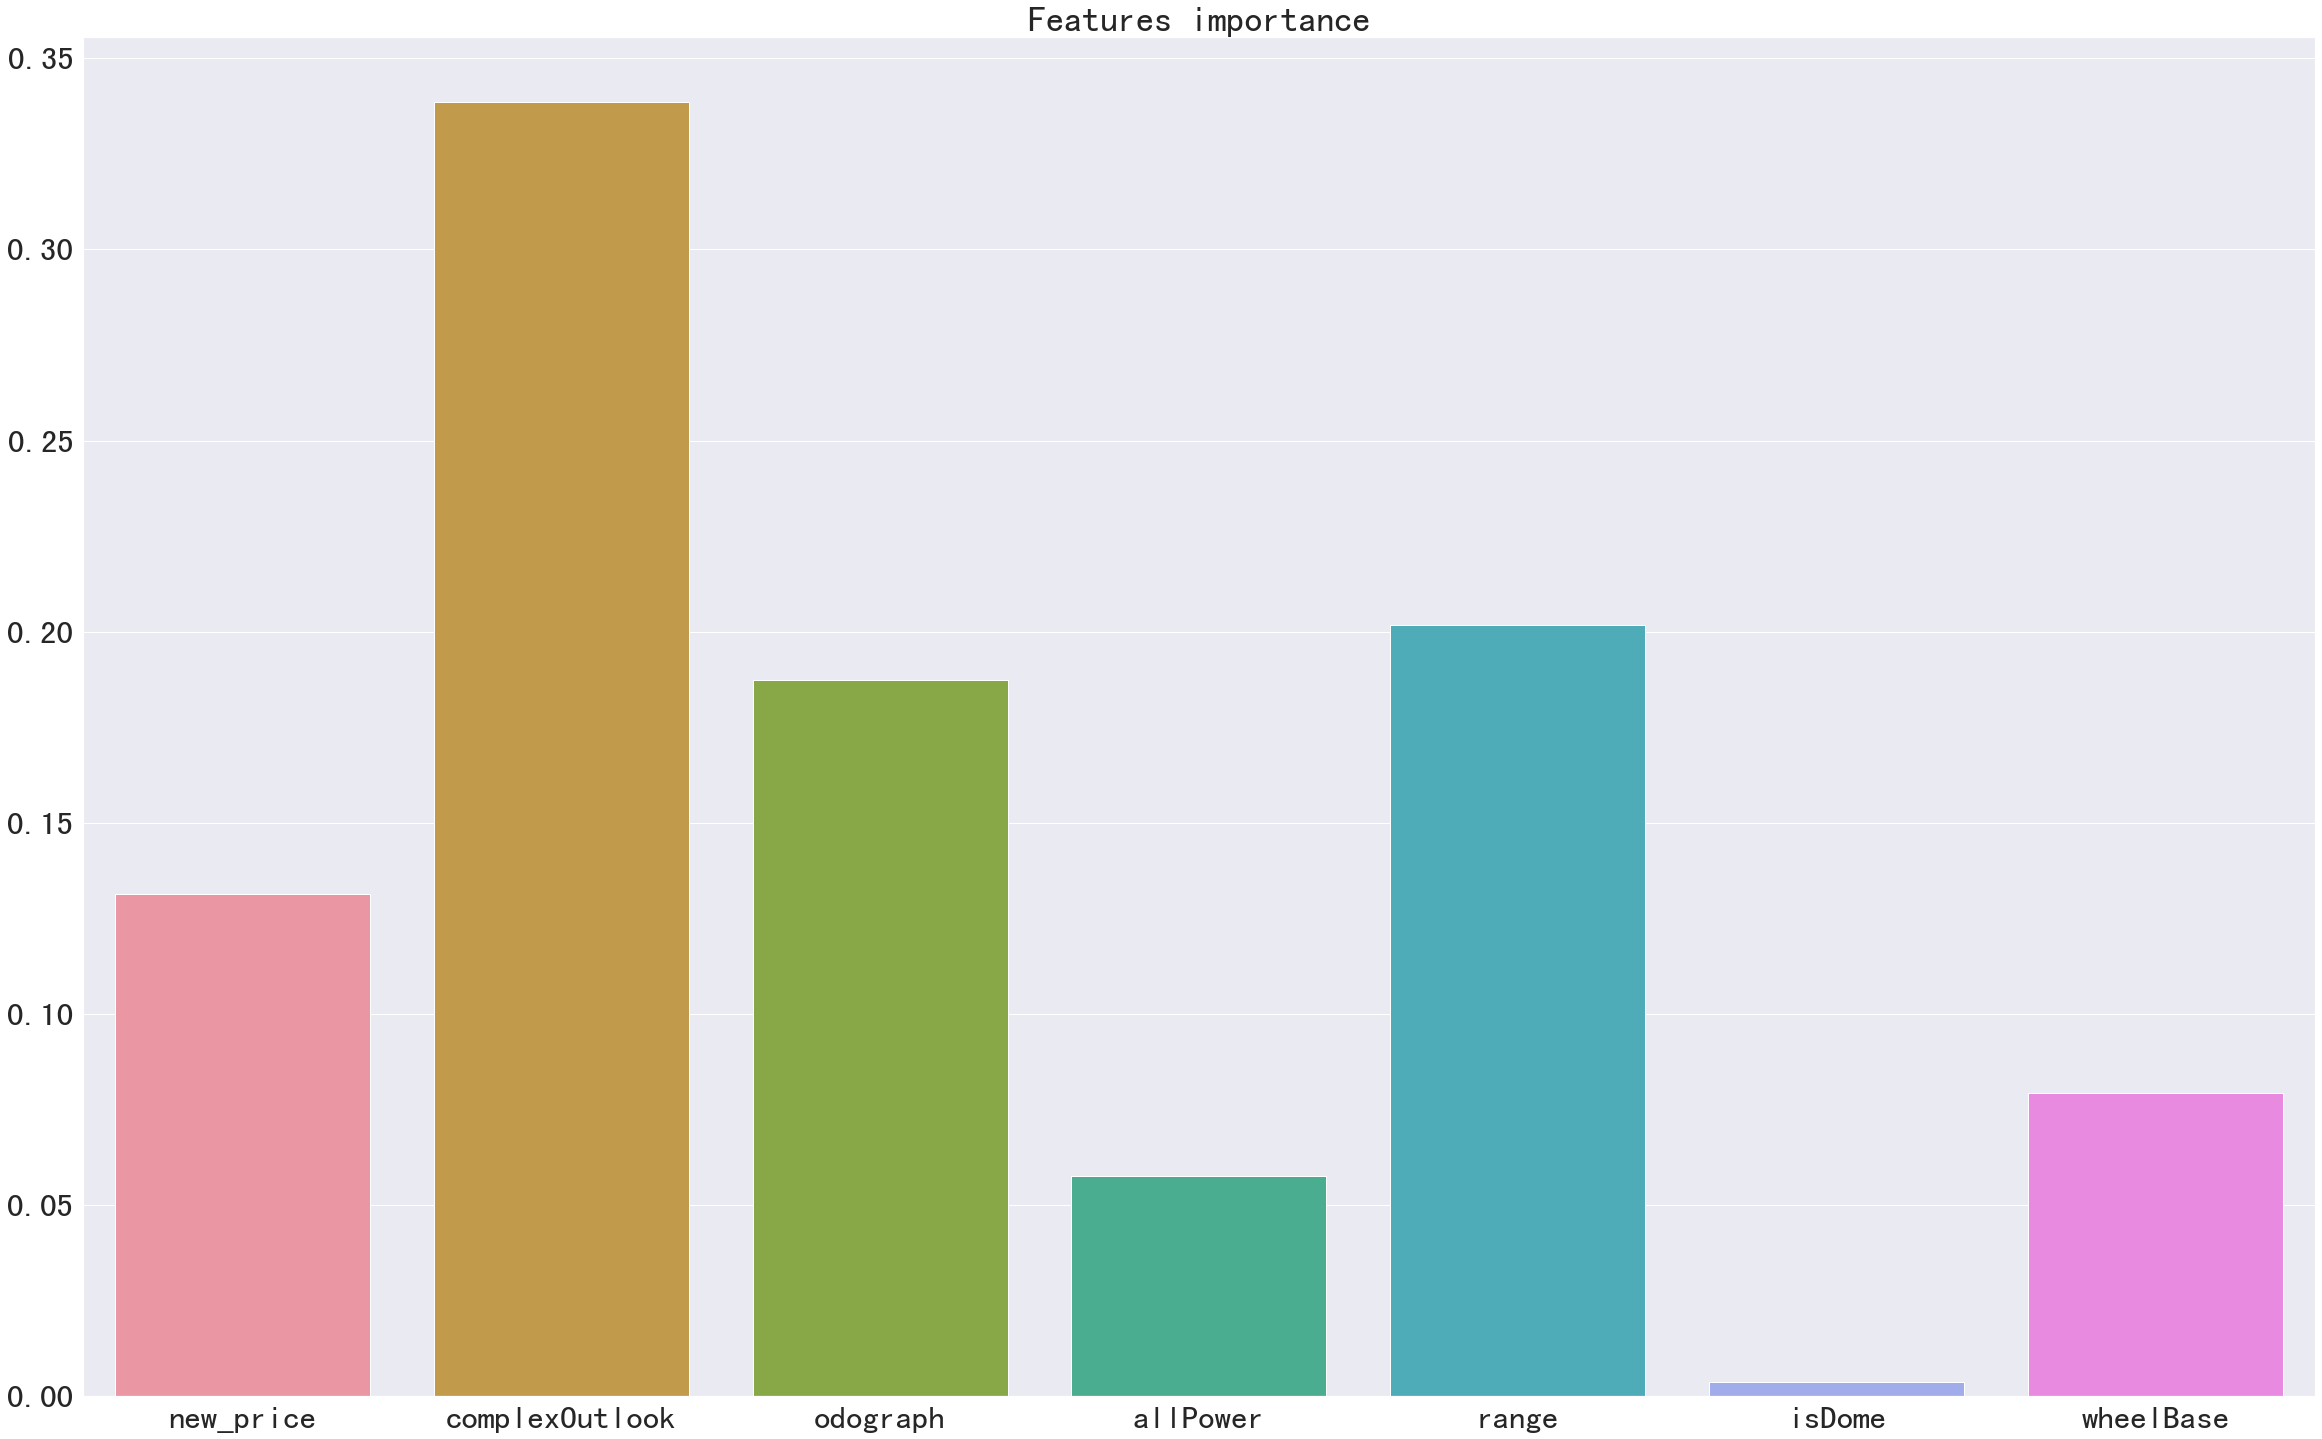

In [30]:
rf_without_time = RandomForestRegressor()
rf_without_time.fit(X_train_without_time, y_train)

fig, ax = plt.subplots(1, 1, figsize=(40, 25))
labels = X_train_without_time.columns
sns.barplot(x=labels, y=rf_without_time.feature_importances_)
ax.set_title('Features importance')
plt.show()

In [31]:
y_predict = rf_without_time.predict(X_test_without_time)

print('RF considering no dummies no time has MAE: ', mean_absolute_error(y_test, y_predict))
print('RF considering no dummies no time has r2 score: ', r2_score(y_test, y_predict))

RF considering no dummies no time has MAE:  0.0630549543241654
RF considering no dummies no time has r2 score:  0.8229593927088622


In [32]:
print(rf_without_time.feature_importances_)

[0.13137849 0.33857164 0.18746458 0.0576804  0.201882   0.0037093
 0.07931359]


调参

In [33]:
# (0.830021177201569,
#  {'max_features': 2,
#   'min_samples_leaf': 1,
#   'min_samples_split': 3,
#   'n_estimators': 40})

# param_test2 = {'n_estimators': range(10,101,10),
#                'max_features': range(1,11,1),
#                'min_samples_leaf': range(1,11,1),
#                'min_samples_split': range(1,11,1)}
# gsearch2 = GridSearchCV(estimator = RandomForestRegressor(), 
#                        param_grid = param_test2)
# gsearch2.fit(X_train_without_time, y_train)
# gsearch2.best_score_, gsearch2.best_params_

保存精度最高的模型到`model/rf_no_dummies_no_time.pickle`

In [34]:
gsearch_result = RandomForestRegressor(n_estimators=40, max_features=2, \
                                min_samples_leaf=1, min_samples_split=3)
gsearch_result.fit(X_train_without_time, y_train)
print('RF considering no dummies no time with best params has MAE: ', mean_absolute_error(y_test, gsearch_result.predict(X_test_without_time)))
print('RF considering no dummies no time with best params has r2 score: ', r2_score(y_test, gsearch_result.predict(X_test_without_time)))
pickle_file = open('rf_no_dummies_no_time.pickle', 'wb')
pickle.dump(gsearch_result, pickle_file)

RF considering no dummies no time with best params has MAE:  0.06423318487905579
RF considering no dummies no time with best params has r2 score:  0.8142620384042891


#### 带dummies，带时间属性的RF

In [35]:
rf_with_dummies_with_time = RandomForestRegressor()
rf_with_dummies_with_time.fit(X_dummies_train, y_dummies_train)

y_predict = rf_with_dummies_with_time.predict(X_dummies_test)
print('RF considering dummies has MAE: ', mean_absolute_error(y_dummies_test, y_predict))
print('RF considering dummies has r2 score: ', r2_score(y_dummies_test, y_predict))

RF considering dummies has MAE:  0.04800650858555916
RF considering dummies has r2 score:  0.8935676902831406


调参

In [36]:
# (0.8402641728501287,
#  {'max_features': 10,
#   'min_samples_leaf': 1,
#   'min_samples_split': 3,
#   'n_estimators': 30})
# param_test = {'n_estimators': range(10,101,10),
#                'max_features': range(1,11,1),
#                'min_samples_leaf': range(1,11,1),
#                'min_samples_split': range(1,11,1)}
# gsearch1 = GridSearchCV(estimator = RandomForestRegressor(), 
#                        param_grid = param_test)
# gsearch1.fit(X_dummies_train, y_dummies_train)
# gsearch1.best_score_, gsearch1.best_params_
gsearch_result = RandomForestRegressor(n_estimators=30, max_features=10, min_samples_leaf=1, min_samples_split=3)
gsearch_result.fit(X_dummies_train, y_dummies_train)
print('RF considering dummies with best params has MAE: ', mean_absolute_error(y_dummies_test, gsearch_result.predict(X_dummies_test)))
print('RF considering dummies with best params has r2 score: ', r2_score(y_dummies_test, gsearch_result.predict(X_dummies_test)))
pickle_file = open('rf_dummies.pickle', 'wb')
pickle.dump(gsearch_result, pickle_file)

RF considering dummies with best params has MAE:  0.06159984562971541
RF considering dummies with best params has r2 score:  0.8321777530343195


#### 带dummies，不带时间属性的RF

In [37]:
rf_with_dummies_without_time = RandomForestRegressor()
rf_with_dummies_without_time.fit(X_dummies_train_without_time, y_dummies_train)

y_predict = rf_with_dummies_without_time.predict(X_dummies_test_without_time)
print('RF considering dummies no time has MAE: ', mean_absolute_error(y_dummies_test, y_predict))
print('RF considering dummies no time has r2 score: ', r2_score(y_dummies_test, y_predict))

RF considering dummies no time has MAE:  0.061746019329575144
RF considering dummies no time has r2 score:  0.8306593786012154


调参

In [38]:
# (0.7974906399418742,
#  {'max_features': 10,
#   'min_samples_leaf': 1,
#   'min_samples_split': 3,
#   'n_estimators': 100})
# param_test = {'n_estimators': range(10,101,10),
#                'max_features': range(1,11,1),
#                'min_samples_leaf': range(1,11,1),
#                'min_samples_split': range(1,11,1)}
# gsearch = GridSearchCV(estimator = RandomForestRegressor(), 
#                        param_grid = param_test)
# gsearch.fit(X_dummies_train_without_time, y_dummies_train)
# gsearch.best_score_, gsearch.best_params_
gsearch_result = RandomForestRegressor(n_estimators=100, max_features=10, min_samples_leaf=1, min_samples_split=3)
gsearch_result.fit(X_dummies_train_without_time, y_dummies_train)
print('RF considering dummies with best params has MAE: ', mean_absolute_error(y_dummies_test, gsearch_result.predict(X_dummies_test_without_time)))
print('RF considering dummies with best params has r2 score: ', r2_score(y_dummies_test, gsearch_result.predict(X_dummies_test_without_time)))
pickle_file = open('rf_dummies_no_time.pickle', 'wb')
pickle.dump(gsearch_result, pickle_file)

RF considering dummies with best params has MAE:  0.06878138892886511
RF considering dummies with best params has r2 score:  0.7961051295698289


### XGBoost回归

#### 不带dummies，带时间属性的XGB

In [39]:
from xgboost import XGBRegressor

xgb_with_time = XGBRegressor()
xgb_with_time.fit(X_train, y_train)
y_predict = xgb_with_time.predict(X_test)
print('XGB considering no dummies has MAE: ', mean_absolute_error(y_test, y_predict))
print('XGB considering no dummies has r2 score: ', r2_score(y_test, y_predict))

XGB considering no dummies has MAE:  0.05024756027564702
XGB considering no dummies has r2 score:  0.8927229403735822


调参

In [40]:
# (0.8938365607311459,
#  {'learning_rate': 0.3,
#   'max_depth': 3,
#   'min_child_weight': 1,
#   'reg_alpha': 0.01})
# param_test = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#                'max_depth': range(3,11,1),
#                'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
#                'min_child_weight':range(1,6,1)}
# gsearch = GridSearchCV(estimator = XGBRegressor(), 
#                        param_grid = param_test)
# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_
gsearch_result = XGBRegressor(learning_rate=0.3, max_depth=3, min_child_weight=1, reg_alpha=0.01)
gsearch_result.fit(X_train, y_train)
print('XGB considering no dummies with best params has MAE: ', mean_absolute_error(y_test, gsearch_result.predict(X_test)))
print('XGB considering no dummies with best params has r2 score: ', r2_score(y_test, gsearch_result.predict(X_test)))
pickle_file = open('xgb_no_dummies.pickle', 'wb')
pickle.dump(gsearch_result, pickle_file)

XGB considering no dummies with best params has MAE:  0.04805281062245829
XGB considering no dummies with best params has r2 score:  0.9037357347772478


#### 不带dummies，不带时间属性的XGB

In [41]:
xgb_without_time = XGBRegressor()
xgb_without_time.fit(X_train_without_time, y_train)
y_predict = xgb_without_time.predict(X_test_without_time)
print('XGB considering no dummies no time has MAE: ', mean_absolute_error(y_test, y_predict))
print('XGB considering no dummies no time has r2 score: ', r2_score(y_test, y_predict))

XGB considering no dummies no time has MAE:  0.05969563902588413
XGB considering no dummies no time has r2 score:  0.8348737377378137


调参

In [42]:
# (0.84528755687551,
#  {'learning_rate': 0.2,
#   'max_depth': 3,
#   'min_child_weight': 1,
#   'reg_alpha': 0.001})
# param_test = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#                'max_depth': range(3,11,1),
#                'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
#                'min_child_weight':range(1,6,1)}
# gsearch = GridSearchCV(estimator = XGBRegressor(), 
#                        param_grid = param_test)
# gsearch.fit(X_train_without_time, y_train)
# gsearch.best_score_, gsearch.best_params_
gsearch_result = XGBRegressor(learning_rate=0.2, max_depth=3, min_child_weight=1, reg_alpha=0.001)
gsearch_result.fit(X_train_without_time, y_train)
print('XGB considering no dummies no time with best params has MAE: ', mean_absolute_error(y_test, gsearch_result.predict(X_test_without_time)))
print('XGB considering no dummies no time with best params has r2 score: ', r2_score(y_test, gsearch_result.predict(X_test_without_time)))
pickle_file = open('xgb_no_dummies_no_time.pickle', 'wb')
pickle.dump(gsearch_result, pickle_file)

XGB considering no dummies no time with best params has MAE:  0.058248505497229756
XGB considering no dummies no time with best params has r2 score:  0.8576546279122748


#### 带dummies，带时间属性的XGB

In [43]:
xgb_with_dummies_with_time = XGBRegressor()
xgb_with_dummies_with_time.fit(X_dummies_train, y_dummies_train)
y_predict = xgb_with_dummies_with_time.predict(X_dummies_test)
print('XGB considering dummies has MAE: ', mean_absolute_error(y_test, y_predict))
print('XGB considering dummies has r2 score: ', r2_score(y_test, y_predict))

XGB considering dummies has MAE:  0.04758273581912998
XGB considering dummies has r2 score:  0.8984065663937342


调参

In [44]:
# (0.9009651622546357,
#  {'learning_rate': 0.3,
#   'max_depth': 3,
#   'min_child_weight': 4,
#   'reg_alpha': 0.001})
# param_test = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#                'max_depth': range(3,11,1),
#                'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
#                'min_child_weight':range(1,6,1)}
# gsearch = GridSearchCV(estimator = XGBRegressor(), 
#                        param_grid = param_test)
# gsearch.fit(X_dummies_train, y_dummies_train)
# gsearch.best_score_, gsearch.best_params_
gsearch_result = XGBRegressor(learning_rate=0.3, max_depth=3, min_child_weight=4, reg_alpha=0.001)
gsearch_result.fit(X_dummies_train, y_dummies_train)
print('XGB considering dummies with best params has MAE: ', mean_absolute_error(y_dummies_test, gsearch_result.predict(X_dummies_test)))
print('XGB considering dummies with best params has r2 score: ', r2_score(y_dummies_test, gsearch_result.predict(X_dummies_test)))
pickle_file = open('xgb_dummies.pickle', 'wb')
pickle.dump(gsearch_result, pickle_file)

XGB considering dummies with best params has MAE:  0.045495308186728534
XGB considering dummies with best params has r2 score:  0.9144164622112487


#### 带dummies，不带时间属性的XGB

In [45]:
xgb_with_dummies_without_time = XGBRegressor()
xgb_with_dummies_without_time.fit(X_dummies_train_without_time, y_dummies_train)
y_predict = xgb_with_dummies_without_time.predict(X_dummies_test_without_time)
print('XGB considering dummies no time has MAE: ', mean_absolute_error(y_test, y_predict))
print('XGB considering dummies no time has r2 score: ', r2_score(y_test, y_predict))

XGB considering dummies no time has MAE:  0.05899483226361553
XGB considering dummies no time has r2 score:  0.8377888616129573


调参

In [46]:
# (0.854109410790627,
#  {'learning_rate': 0.3,
#   'max_depth': 3,
#   'min_child_weight': 5,
#   'reg_alpha': 0.05})
# param_test = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#                'max_depth': range(3,11,1),
#                'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
#                'min_child_weight':range(1,6,1)}
# gsearch = GridSearchCV(estimator = XGBRegressor(), 
#                        param_grid = param_test)
# gsearch.fit(X_dummies_train_without_time, y_dummies_train)
# gsearch.best_score_, gsearch.best_params_
gsearch_result = XGBRegressor(learning_rate=0.3, max_depth=3, min_child_weight=5, reg_alpha=0.05)
gsearch_result.fit(X_dummies_train_without_time, y_dummies_train)
print('XGB considering dummies no time with best params has MAE: ', mean_absolute_error(y_dummies_test, gsearch_result.predict(X_dummies_test_without_time)))
print('XGB considering dummies no time with best params has r2 score: ', r2_score(y_dummies_test, gsearch_result.predict(X_dummies_test_without_time)))
pickle_file = open('xgb_dummies_no_time.pickle', 'wb')
pickle.dump(gsearch_result, pickle_file)

XGB considering dummies no time with best params has MAE:  0.056442693116176834
XGB considering dummies no time with best params has r2 score:  0.8719020413004634


### LightGBM回归

#### 不带dummies，带时间属性的LGB

In [47]:
from lightgbm import LGBMRegressor

lgb_with_time = LGBMRegressor()
lgb_with_time.fit(X_train, y_train)
y_predict = lgb_with_time.predict(X_test)
print('LGB considering no dummies has MAE: ', mean_absolute_error(y_test, y_predict))
print('LGB considering no dummies has r2 score: ', r2_score(y_test, y_predict))

LGB considering no dummies has MAE:  0.0490832840324796
LGB considering no dummies has r2 score:  0.8926044892104498


调参

In [48]:
# param_test={
#     'min_child_samples': [18, 19, 20, 21, 22],
#     'min_child_weight':[0.001, 0.002]
# }
# gsearch = GridSearchCV(estimator=LGBMRegressor(max_depth=6, num_leaves=9, min_child_samples=18, min_child_weight=0.001), param_grid=param_test)
# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_
gsearch_result = LGBMRegressor(max_depth=6, num_leaves=9, min_child_samples=18, min_child_weight=0.001)
gsearch_result.fit(X_train, y_train)
print('LGB considering no dummies with best params has MAE: ', mean_absolute_error(y_test, gsearch_result.predict(X_test)))
print('LGB considering no dummies with best params has r2 score: ', r2_score(y_test, gsearch_result.predict(X_test)))
pickle_file = open('lgb_no_dummies.pickle', 'wb')
pickle.dump(gsearch_result, pickle_file)

LGB considering no dummies with best params has MAE:  0.04935986538432926
LGB considering no dummies with best params has r2 score:  0.8940646125881823


#### 不带dummies，不带时间属性的LGB

In [49]:
lgb_without_time = LGBMRegressor()
lgb_without_time.fit(X_train_without_time, y_train)
y_predict = lgb_without_time.predict(X_test_without_time)
print('LGB considering no dummies no time has MAE: ', mean_absolute_error(y_test, y_predict))
print('LGB considering no dummies no time has r2 score: ', r2_score(y_test, y_predict))

LGB considering no dummies no time has MAE:  0.058944904092490556
LGB considering no dummies no time has r2 score:  0.8574354083968785


调参

In [50]:
# (0.840362737573131,
#  {'max_depth': 4,
#   'min_child_samples': 18,
#   'min_child_weight': 0.001,
#   'num_leaves': 20})
# param_test={
#     'max_depth':[4],
#     'num_leaves':range(12,18,1),
#     'min_child_samples':[18,19,20,21,22],
#     'min_child_weight':[0.001]
# }
# gsearch = GridSearchCV(estimator=LGBMRegressor(), param_grid=param_test)
# gsearch.fit(X_train_without_time, y_train)
# gsearch.best_score_, gsearch.best_params_
gsearch_result = LGBMRegressor(max_depth=-1, num_leaves=31, min_child_samples=20, min_child_weight=0.001)
gsearch_result.fit(X_train_without_time, y_train)
print('LGB considering no dummies no time with best params has MAE: ', mean_absolute_error(y_test, gsearch_result.predict(X_test_without_time)))
print('LGB considering no dummies no time with best params has r2 score: ', r2_score(y_test, gsearch_result.predict(X_test_without_time)))
pickle_file = open('lgb_no_dummies_no_time.pickle', 'wb')
pickle.dump(gsearch_result, pickle_file)

LGB considering no dummies no time with best params has MAE:  0.058944904092490556
LGB considering no dummies no time with best params has r2 score:  0.8574354083968785


#### 带dummies，带时间属性的LGB

In [51]:
lgb_with_dummies_with_time = LGBMRegressor()
lgb_with_dummies_with_time.fit(X_dummies_train, y_dummies_train)
y_predict = lgb_with_dummies_with_time.predict(X_dummies_test)
print('LGB considering dummies has MAE: ', mean_absolute_error(y_dummies_test, y_predict))
print('LGB considering dummies has r2 score: ', r2_score(y_dummies_test, y_predict))

LGB considering dummies has MAE:  0.0495656009490976
LGB considering dummies has r2 score:  0.8931027813568913


调参

In [52]:
# (0.8878569402257981,
#  {'learning_rate': 0.1,
#   'max_depth': 7,
#   'min_child_samples': 19,
#   'min_child_weight': 0.001,
#   'num_leaves': 25})
# param_test={
#     'learning_rate':[0.001,0.005,0.01,0.05,0.1],
#     'max_depth':range(-1,8,1),
#     'num_leaves':range(25,35,1),
#     'min_child_samples':[18,19,20,21,22],
#     'min_child_weight':[0.001,0.002]
# }
# gsearch = GridSearchCV(estimator=LGBMRegressor(), param_grid=param_test)
# gsearch.fit(X_dummies_train, y_dummies_train)
# gsearch.best_score_, gsearch.best_params_
gsearch_result = LGBMRegressor(max_depth=-1, num_leaves=31, min_child_samples=20, min_child_weight=0.001, learning_rate=0.1)
gsearch_result.fit(X_dummies_train, y_dummies_train)
print('LGB considering dummies with best params has MAE: ', mean_absolute_error(y_dummies_test, gsearch_result.predict(X_dummies_test)))
print('LGB considering dummies with best params has r2 score: ', r2_score(y_dummies_test, gsearch_result.predict(X_dummies_test)))
pickle_file = open('lgb_dummies.pickle', 'wb')
pickle.dump(gsearch_result, pickle_file)

LGB considering dummies with best params has MAE:  0.0495656009490976
LGB considering dummies with best params has r2 score:  0.8931027813568913


#### 带dummies，不带时间属性的LGB

In [53]:
xgb_with_dummies_without_time = XGBRegressor()
xgb_with_dummies_without_time.fit(X_dummies_train_without_time, y_dummies_train)
y_predict = xgb_with_dummies_without_time.predict(X_dummies_test_without_time)
print('XGB considering dummies no time has MAE: ', mean_absolute_error(y_dummies_test, y_predict))
print('XGB considering dummies no time has r2 score: ', r2_score(y_dummies_test, y_predict))

XGB considering dummies no time has MAE:  0.05899483226361553
XGB considering dummies no time has r2 score:  0.8377888616129573


调参

In [54]:
# (0.8396688361466884,
#  {'learning_rate': 0.1,
#   'max_depth': 6,
#   'min_child_samples': 19,
#   'min_child_weight': 0.001,
#   'num_leaves': 25})
# param_test={
#     'learning_rate':[0.001,0.005,0.01,0.05,0.1],
#     'max_depth':range(-1,8,1),
#     'num_leaves':range(25,35,1),
#     'min_child_samples':[18,19,20,21,22],
#     'min_child_weight':[0.001,0.002]
# }
# gsearch = GridSearchCV(estimator = LGBMRegressor(), 
#                        param_grid = param_test)
# gsearch.fit(X_dummies_train_without_time, y_dummies_train)
# gsearch.best_score_, gsearch.best_params_
gsearch_result = LGBMRegressor(max_depth=6, num_leaves=25, min_child_samples=19, min_child_weight=0.001, learning_rate=0.1)
gsearch_result.fit(X_dummies_train_without_time, y_dummies_train)
print('LGB considering dummies no time with best params has MAE: ', mean_absolute_error(y_dummies_test, gsearch_result.predict(X_dummies_test_without_time)))
print('LGB considering dummies no time with best params has r2 score: ', r2_score(y_dummies_test, gsearch_result.predict(X_dummies_test_without_time)))
pickle_file = open('lgb_dummies_no_time.pickle', 'wb')
pickle.dump(gsearch_result, pickle_file)

LGB considering dummies no time with best params has MAE:  0.0606954579812859
LGB considering dummies no time with best params has r2 score:  0.8549187151545716


### Stacking集成

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
level0 = list()
level0.append(('rf', RandomForestRegressor(n_estimators=30, max_features=10, min_samples_leaf=1, min_samples_split=3)))
level0.append(('xgboost', XGBRegressor(learning_rate=0.3, max_depth=3, min_child_weight=4, reg_alpha=0.001)))
level0.append(('lightGBM', LGBMRegressor(max_depth=-1, num_leaves=31, min_child_samples=20, min_child_weight=0.001, learning_rate=0.1)))
level1 = LinearRegression()
StackingModel=StackingRegressor(estimators=level0,final_estimator=level1,cv=5)

StackingModel.fit(X_dummies_train, y_dummies_train)
y_predict = StackingModel.predict(X_dummies_test)
print('Stacking considering dummies has MAE: ', mean_absolute_error(y_test, y_predict))
print('Stacking considering dummies has r2 score: ', r2_score(y_test, y_predict))

Stacking considering dummies has MAE:  0.0442047714338476
Stacking considering dummies has r2 score:  0.9166441911468814


## 对比与总结

1. 特征值不带车辆品牌、型号、归属地、驱动方式字段，带时间字段

    | **no dummies, with time**    | **MAE**              | **r2_score**       |
    |------------------------------|----------------------|--------------------|
    | RF                           | 0.05126382073502803  | 0.8749485042364266 |
    | XGBoost                      | 0.04805281062245829  | 0.9037357347772478 |
    | LightGBM                     | 0.04935986538432926  | 0.8940646125881823 |


2. 特征值不带车辆品牌、型号、归属地、驱动方式字段，也不带时间字段

    | **no dummies, no time**   | **MAE**              | **r2_score**       |
    |---------------------------|----------------------|--------------------|
    | RF                        | 0.0666308339566012   | 0.8051720647950329 |
    | XGBoost                   | 0.058248505497229756 | 0.8576546279122748 |
    | LightGBM                  | 0.058944904092490556 | 0.8574354083968785 |


3. 特征值带车辆品牌、型号、归属地、驱动方式字段，带时间字段

    | **with dummies, with time** | **MAE**              | **r2_score**       |
    |-----------------------------|----------------------|--------------------|
    | RF                          | 0.06070270631725487  | 0.8380696437381363 |
    | XGBoost                     | 0.045495308186728534 | 0.9144164622112487 |
    | LightGBM                    | 0.0495656009490976   | 0.8931027813568913 |


4. 特征值带车辆品牌、型号、归属地、驱动方式字段，不带时间字段

    | **with dummies, no time** | **MAE**              | **r2_score**       |
    |---------------------------|----------------------|--------------------|
    | RF                        | 0.06931294102607148  | 0.7937360306170568 |
    | XGBoost                   | 0.056442693116176834 | 0.8719020413004634 |
    | LightGBM                  | 0.0606954579812859   | 0.8549187151545716 |